In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U imbalanced-learn scikit-learn==1.4 shap phik seaborn==0.13.1 optuna optuna-integration catboost

In [ ]:
import imblearn
from imblearn.over_sampling import SMOTENC

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report, recall_score, precision_score
from sklearn.feature_selection import SelectKBest, f_classif

import phik
from phik.report import plot_correlation_matrix
from phik import phik_matrix

from imblearn.combine import SMOTETomek
from imblearn.base import FunctionSampler
from imblearn.pipeline import make_pipeline as make_imblearn_pipeline

import optuna

from catboost import CatBoostClassifier

import shap

0.12.2


# Startups operations/close predictions

The current research is aimed at the anylysis of the data on startups operating between 1980 and 2018. The result of the research is the model predicting the startup closure based on such parameters as its category, funding rounds quantity and total funding amount, dates of foundation, first and last funding.  
In order to define the startups closing, the following steps will be taken:
1. Data overview
2. Data preprocessing
3. Exploratory data analysis
4. Creating new features
5. Correlation analysis
6. Model training
7. Model evaluation
8. Model correction
9. Features importance analysis
10. Conclusion

## 1 Data overview

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/startups/kaggle_startups_train_01.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/startups/kaggle_startups_test_01.csv')

In [ ]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52879 entries, 0 to 52878
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52878 non-null  object 
 1   category_list      50374 non-null  object 
 2   funding_total_usd  42753 non-null  float64
 3   status             52879 non-null  object 
 4   country_code       47351 non-null  object 
 5   state_code         46082 non-null  object 
 6   region             46489 non-null  object 
 7   city               46489 non-null  object 
 8   funding_rounds     52879 non-null  int64  
 9   founded_at         52879 non-null  object 
 10  first_funding_at   52858 non-null  object 
 11  last_funding_at    52879 non-null  object 
 12  closed_at          4962 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB
None


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,NaN


In [ ]:
train['name'].duplicated().sum()

0

Train data contains 52 879 entries with unique ids (names) with the following columns:  
- name - startup name
- category_list - list of startup categories
- funding_total_usd - total amount of funding, USD
- status - sturtup status (closed / operating)
- country_code - country code
- state_code - state code
- region - region
- city - city
- funding_rounds - quantity of funding rounds
- founded_at - foundation date
- first_funding_at - first funding round date
- last_funding_at - last funding round date
- closed_at - startup closing date (if applicable)

In [ ]:
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13211 entries, 0 to 13210
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13211 non-null  object 
 1   category_list      12610 non-null  object 
 2   funding_total_usd  10616 non-null  float64
 3   country_code       11827 non-null  object 
 4   state_code         11512 non-null  object 
 5   region             11618 non-null  object 
 6   city               11620 non-null  object 
 7   funding_rounds     13211 non-null  int64  
 8   founded_at         13211 non-null  object 
 9   first_funding_at   13211 non-null  object 
 10  last_funding_at    13211 non-null  object 
 11  closed_at          1234 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 1.2+ MB
None


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,NaN
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,NaN
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,NaN
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,NaN
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,NaN


Test data contains 13211 entries with the identical columns

## 2 Data prepocessing

In this part the data preprocessig will be conducted in order to exclude empty value and incorrect data types.

In [ ]:
print('Пропуски в тренировочных данных:')
pd.DataFrame(train.isna().mean().to_frame(name='empty_values').query('empty_values > 0')['empty_values'])\
            .style.background_gradient('coolwarm')\
            .format({'empty_values' : '{:.2%}'})

Пропуски в тренировочных данных:


,empty_values
name,0.00%
category_list,4.74%
funding_total_usd,19.15%
country_code,10.45%
state_code,12.85%
region,12.08%
city,12.08%
first_funding_at,0.04%
closed_at,90.62%


Train data contains empty values in the following columns: `name`, `category_list`, `funding_total_usd`, `country_code`, `state_code`, `region`, `city`, `first_funding_at`, `closed_at`.

In [ ]:
train[(train['country_code'].isna()) & (train['funding_total_usd'].isna()) & (train['category_list'].isna())]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-09-26
24,Savasti,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2015-01-01,2015-01-01,2015-01-01,2016-03-19
65,Seamless Logistics,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2009-03-26,2011-02-01,2011-02-01,NaN
79,Efficient Photon,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2009-11-11,2011-09-22,2011-09-22,2013-04-21
156,Public Post,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2007-12-08,2008-08-14,2008-08-14,2009-12-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52690,Connexions,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2010-07-11,2012-05-01,2012-05-01,NaN
52740,Maremonti,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2011-09-12,2013-08-01,2013-08-01,NaN
52757,Ogg Trading,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2014-08-30,2015-06-01,2015-06-01,NaN
52767,Beach Bum,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2014-08-11,2015-05-18,2015-05-18,2017-03-22


In [ ]:
train = train.drop(train[(train['country_code'].isna()) & (train['funding_total_usd'].isna()) & (train['category_list'].isna())].index)

There are several rows with no data on startup's category, total funding, location. Due to the fact that the share is less than 2% of all data, these rows will be deleted.

In [ ]:
train = train.drop(train[train['first_funding_at'].isna()].index)
train = train.drop(train[train['name'].isna()].index)

For the same reason, the rows with empty values in `name` and `funding_total_usd` will be also deleted.

In [ ]:
# filling empty country codes with the most frequent one
def get_country_code(df):
    df['country_code'] = df['country_code'].fillna(df['country_code'].value_counts().index[0])

# filling empty fundings with the average amount for each country
def get_total_funding(df):
    for country in df['country_code'].unique():
        if df[df['country_code'] == country]['funding_total_usd'].mean() > 0:
            df.loc[df['country_code'] == country, 'funding_total_usd'] = \
                df[df['country_code'] == country]['funding_total_usd'].fillna(df[df['country_code'] == country]['funding_total_usd'].mean())
        else:
            df.loc[df['country_code'] == country, 'funding_total_usd'] = \
                df[df['country_code'] == country]['funding_total_usd'].fillna(df['funding_total_usd'].mean())

# filling empty regions and cities with the most frequent ones by country
def get_regions_cities(df):
    for country in df['country_code'].unique():
        if df[df['country_code'] == country]['region'].count() > 0:
            df.loc[df['country_code'] == country, 'region'] = df[df['country_code'] == country]['region'] \
                .fillna(df[df['country_code'] == country]['region'].value_counts().index[0])
            df.loc[df['country_code'] == country, 'city'] = df[df['country_code'] == country]['city'] \
                .fillna(df[df['region'] == df[df['country_code'] == country]['region'].value_counts().index[0]]['city'].value_counts().index[0])
        else:
            df.loc[df['country_code'] == country, 'region'] = df[df['country_code'] == country]['region'].fillna(country + ' - Other')
            df.loc[df['country_code'] == country, 'city'] = df[df['country_code'] == country]['city'].fillna(country + ' - Other')

# filling empty state_codes by region
def get_state_codes(df):
    for region in df[df['state_code'].isna()]['region'].unique():
        if df[df['region'] == region]['state_code'].count() > 0:
            df.loc[df['region'] == region, 'state_code'] = df[df['region'] == region]['state_code'] \
                .fillna(df[df['region'] == region]['state_code'].value_counts().index[0])
        else:
            df.loc[df['region'] == region, 'state_code'] = df[df['region'] == region]['state_code'] \
                .fillna(df[df['region'] == region]['country_code'] + ' - Other')

# filling empty closing date
def get_current_date(df):
    df['closed_at'] = df['closed_at'].fillna('2018-01-01')

# grouping categories
def define_cat(list_of_cats):
    cat = []
    for c in list_of_cats:
        if c in ['Biotechnology', 'Health Care', 'Health and Wellness', 'Medical', 'Medical Devices', 'Pharmaceuticals', 'Health Diagnostics',  'Health Care Information Technology'] and 'Medicine' not in cat:
            cat.append('Medicine')
        elif c in ['Software', 'Mobile', 'Curated Web', 'Social Media', 'Enterprise Software', 'SaaS', 'Apps', 'Hardware + Software', 'Big Data', 'Cloud Computing', 'Information Technology', 'Networking',
                   'FinTech', 'Web Hosting', 'Web Development', 'Android', 'iPhone', 'Telecommunications', 'EdTech', 'Location Based Services', 'Internet of Things', 'Big Data Analytics', 'Wireless', 'iOS', 'Internet'] and 'IT' not in cat:
            cat.append('IT')
        elif c in ['Analytics', 'Finance', 'Services', 'Security', 'Consulting', 'Real Estate', 'Search', 'Startups', 'Education', 'Business Services', 'Collaboration', 'Recruiting', 'Service Providers', 'Human Resources', 'Real Time', 'CRM',
                   'Crowdsourcing', 'Customer Service', 'Public Relations'] and 'Services' not in cat:
            cat.append('Services')
        elif c in ['E-Commerce', 'Advertising', 'Marketplaces', 'Sales and Marketing', 'Retail', 'Financial Services', 'Payments', 'B2B', 'Mobile Commerce', 'Consumer Goods', 'Online Shopping', 'Brand Marketing', 'Internet Marketing',
                   'Reviews and Recommendations', 'Social Commerce', 'Mobile Payments', 'Public Transportation'] and 'Commerce' not in cat:
            cat.append('Commerce')
        elif c in ['Games', 'Video', 'Fashion', 'Entertainment', 'Travel', 'Music', 'Media', 'Social Network Media', 'News', 'Hospitality', 'Sports', 'Design', 'Messaging', 'Digital Media', 'Photography',
                   'Events', 'Content', 'Publishing', 'Fitness', 'Restaurants', 'Video Streaming', 'Facebook Applications'] and 'Entertainment' not in cat:
            cat.append('Entertainment')
        elif c in ['Clean Technology', 'Technology', 'Manufacturing', 'Semiconductors', 'Automotive', 'Transportation', 'Consumer Electronics', 'Enterprises', 'Energy', 'Nanotechnology'] and 'Manufacturing' not in cat:
            cat.append('Manufacturing')
        #if len(cat) == 2: break
    return 'Other' if len(cat)==0 else ", ".join(str(element) for element in cat)

def get_main_cat(df):
    df.loc[~df['category_list'].isna(), 'category_list'] = df.loc[~df['category_list'].isna()]['category_list'].apply(lambda x: x.split('|'))
    df['main_cat'] = df[~df['category_list'].isna()]['category_list'].apply(lambda x: define_cat(x))

    #df['main_cat'] = df['main_cat'].fillna('Other')
    '''
    for region in df['region'].unique():
        if df[df['region'] == region]['main_cat'].count() > 0:
            df.loc[df['region'] == region, 'main_cat'] = df[df['region'] == region]['main_cat'].fillna(df[df['region'] == region]['main_cat'].value_counts().index[0])
        else:
            df.loc[df['region'] == region, 'main_cat'] = df[df['region'] == region]['main_cat'].fillna('df['main_cat'].value_counts().index[0]')
    '''
    df.drop('category_list', axis=1, inplace=True)

Steps implemented to fulfill empty values:
- The empty country codes to be filled with the most frequent one
- The empty fundings to be filled with the average amount for each country
- The empty regions to be filled with the most frequent ones by country
- The empty cities to be filled with  the most frequent ones by region
- The empty state_codes to be filled by region
- The empty closing dates to be filled with the unloading date

For further analysis the research of the `category_list` data was conducted.
The data in `category_list` will be transformed and divided into 7 large thematic groups: Medicine, IT, Services, Commerce, Entertainment, Manufacturing, and Other. A startup can belong to multiple categories

In [ ]:
def transform_data(df):
    get_country_code(df)
    get_total_funding(df)
    get_regions_cities(df)
    get_state_codes(df)
    get_current_date(df)
    get_main_cat(df)

In [ ]:
transform_data(train)

In [ ]:
print('Пропуски в тренировочных данных:')
pd.DataFrame(train.isna().mean().to_frame(name='empty_values').query('empty_values > 0')['empty_values'])\
            .style.background_gradient('coolwarm')\
            .format({'empty_values' : '{:.2%}'})

Пропуски в тренировочных данных:


,empty_values
main_cat,3.12%


In [ ]:
train.drop(train[train['main_cat'].isna()].index, inplace=True)

The empty categories will be deleted

During the preprocessing, all empty values were fulfilled

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50353 entries, 0 to 52878
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               50353 non-null  object 
 1   funding_total_usd  50353 non-null  float64
 2   status             50353 non-null  object 
 3   country_code       50353 non-null  object 
 4   state_code         50353 non-null  object 
 5   region             50353 non-null  object 
 6   city               50353 non-null  object 
 7   funding_rounds     50353 non-null  int64  
 8   founded_at         50353 non-null  object 
 9   first_funding_at   50353 non-null  object 
 10  last_funding_at    50353 non-null  object 
 11  closed_at          50353 non-null  object 
 12  main_cat           50353 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.4+ MB


In [ ]:
for column in ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']:
    train[column] = pd.to_datetime(train[column], format='%Y-%m-%d')

The type of columns `founded at`, `first_funding_at`, `last_funding_at`, `closed_at` was transformed into datetime type. Other columns have the correct data type

**Conclusion**  
During the preprocessing, all empty values were fulfilled or deleted if possible. The data on startups' category was transformed: each startup was assigned to a thematic group or multiple groups. Moreover, the correct data types were set.

## 3 Exploratory data analysis

In this part the exploratory data analysis will be conducted. Also, the outliners will be droped in order to get a higher prediction quality.

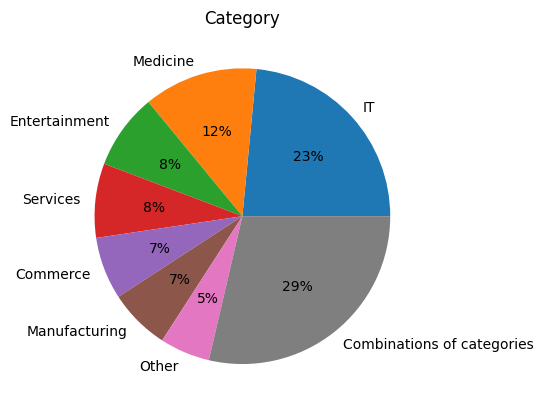

In [ ]:
df_cat = train['main_cat'].value_counts().head(7)
df_cat.loc['Combinations of categories'] = train['main_cat'].value_counts().sum() - train['main_cat'].value_counts().head(7).sum()
ax = df_cat.plot.pie(autopct='%1.0f%%', labels=df_cat.index)
plt.title('Category')
ax.set_ylabel('');

After the previous categorization, IT sturtups take the highest share (23%). Single-category startups all together (Medicine, Entertainment, Services, Commerce, Manufacturing, Other) are accounted for almost a half of all startups. The sturtups with multiple categories have almost a one third.

In [ ]:
def get_info(df, column):
    print(f'Interquartile range is from {df[column].quantile(0.25).round(2)} to {df[column].quantile(0.75).round(2)}')
    print(f'Maximum value is {df[column].max().round(2)}')
    print(f'Minimum value is {df[column].min().round(2)}')
    print(f'Median value is {df[column].mean().round(2)}')

# function to drop outliers with no saving, returns new dataframe with no outliers

def drop_outliers(df, column):

    lower = df.loc[df[column].notna()][column].quantile(0.25)
    higher = df.loc[df[column].notna()][column].quantile(0.75)
    iqr = higher - lower
    if lower - iqr < df.loc[df[column].notna()][column].min():
        min_value = df.loc[df[column].notna()][column].min()
    else:
        min_value = lower - iqr
    if higher + iqr > df.loc[df[column].notna()][column].max():
        max_value = df.loc[df[column].notna()][column].max()
    else:
        max_value = higher + iqr

    print(f'The upper bound of {column} after dropping the outliners is {max_value.round(2)}')
    print(f'The lower bound of {column} after dropping the outliners is {min_value.round(2)}')

    df_new = df.drop(df[(df[column].notna()) & ((df[column] > max_value) | (df[column] < min_value)) ].index)

    return df_new

def show_graphs(df, column):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,2))
    df[column].plot(kind='hist', bins=30, ax=axes[0])
    axes[0].set_title('Distribution')
    df[column].plot(kind='box',   ax=axes[1], rot=45)
    axes[1].set_title('Spread')
    plt.show()

def show_changes(df, column):
    show_graphs(df, column)
    get_info(df, column)
    print()
    df = drop_outliers(df, column)
    show_graphs(df, column)
    get_info(df, column)
    return df

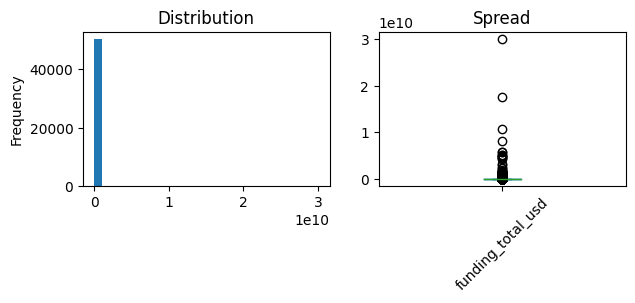

Interquartile range is from 500000.0 to 20443109.08
Maximum value is 30079503000.0
Minimum value is 1.0
Median value is 19084573.34

The upper bound of funding_total_usd after dropping the outliners is 40386218.17
The lower bound of funding_total_usd after dropping the outliners is 1.0


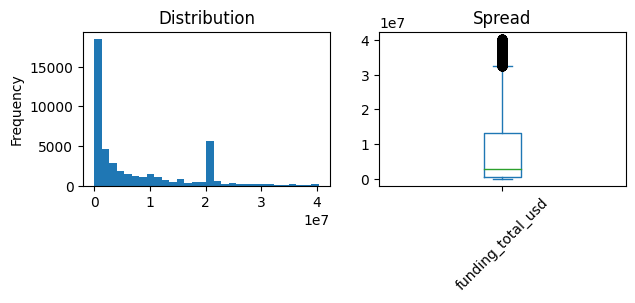

Interquartile range is from 446773.0 to 13261989.41
Maximum value is 40315041.0
Minimum value is 1.0
Median value is 7552233.36


In [ ]:
train = show_changes(train, 'funding_total_usd')

The set of `funding_total_usd` had statistical outliners which additionally were abnormal. The statistical outliners for `funding_total_usd` were excluded.  
Maximum value is 40315041.0  
Minimum value is 1.0  
Median value is 7552233.36

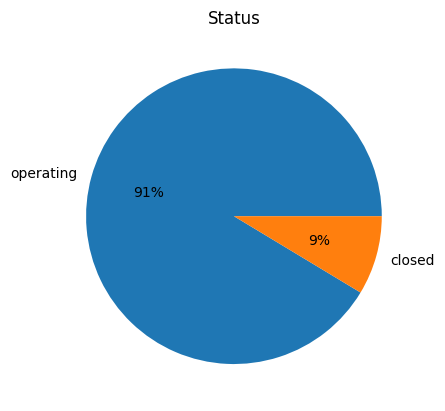

In [ ]:
ax = train['status'].value_counts().plot.pie(autopct='%1.0f%%', labels=train['status'].value_counts().index)
plt.title('Status')
ax.set_ylabel('');

The status is clearly imbalanced. 91% of startups are operating. 9% of startups are closed

In [ ]:
def show_top_ten(df, column):
    print('Unique: ', len(df[column].unique()))
    return pd.concat([df[column].value_counts().head(10), df[column].value_counts(normalize=True).head(10)], axis=1)

In [ ]:
show_top_ten(train, 'country_code')

Unique:  132


,count,proportion
country_code,,
USA,30711,0.661191
GBR,2731,0.058797
CAN,1436,0.030916
IND,1167,0.025125
FRA,861,0.018537
CHN,772,0.016621
DEU,763,0.016427
ISR,713,0.015350
ESP,587,0.012638


The sturtup country distribution is also imbalanced. The USA takes over 66%, while Great Britain from the second place takes less then 6%. Other countries in the top 10 are Canada, India, France, Germane, China, Israel, Spain, Australia

In [ ]:
show_top_ten(train, 'state_code')

Unique:  314


,count,proportion
state_code,,
CA,13095,0.281928
NY,2887,0.062156
MA,1720,0.037031
H9,1498,0.032251
TX,1378,0.029668
7,1043,0.022455
FL,950,0.020453
WA,912,0.019635
2,836,0.017999


California has the highest quantity of startups, almost 30% of the total number. The other states have much lower statistics. In general, there are 314 unique states in the dataset

In [ ]:
show_top_ten(train, 'region')

Unique:  1020


,count,proportion
region,,
SF Bay Area,10264,0.220978
New York City,2565,0.055223
London,1867,0.040195
Boston,1602,0.034490
Los Angeles,1375,0.029603
Seattle,872,0.018774
"Washington, D.C.",743,0.015996
Chicago,703,0.015135
Tel Aviv,615,0.013241


As it's expected, the most popular region is located in California. The share of San Francisco Bay Area is over 22%. New York City has the share of 5.5%, and London is accounted for, while other regions are less than 4%.

In [ ]:
show_top_ten(train, 'city')

Unique:  4298


,count,proportion
city,,
San Francisco,6827,0.146982
New York,2288,0.049259
London,1574,0.033887
Los Angeles,556,0.011970
Austin,548,0.011798
Palo Alto,543,0.011690
Seattle,542,0.011669
Chicago,498,0.010722
Paris,498,0.010722


San Francisco is the most popular city (over 14%). Other cities are New York, London, Los Angeles, etc. Overall, 4298 unique cities are presented.

count    46448.000000
mean         1.618455
std          1.133463
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         18.000000
Name: funding_rounds, dtype: float64

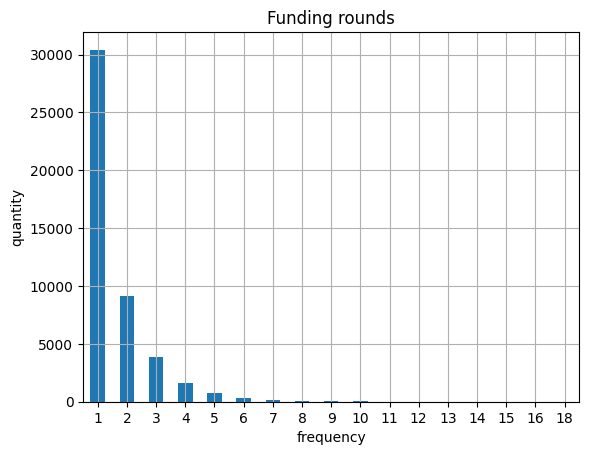

In [ ]:
ax = train['funding_rounds'].value_counts().sort_index().plot.bar(rot=0,grid=True)
plt.title('Funding rounds')
ax.set_xlabel('frequency')
ax.set_ylabel('quantity');
train['funding_rounds'].describe()

The distribution of `funding_rounds` is right-skewed. Most of the startups (over 30 000) had the only round. The highest number of funding rounds is 18.

In [ ]:
def show_dates(df):
    fig, axes = plt.subplots(nrows=1, ncols=len(df.select_dtypes(include=['datetime64']).columns), figsize=(20,2))
    for n, column in enumerate(df.select_dtypes(include=['datetime64']).columns):
        df[column].hist(bins=50, ax=axes[n])
        axes[n].set_title(column)

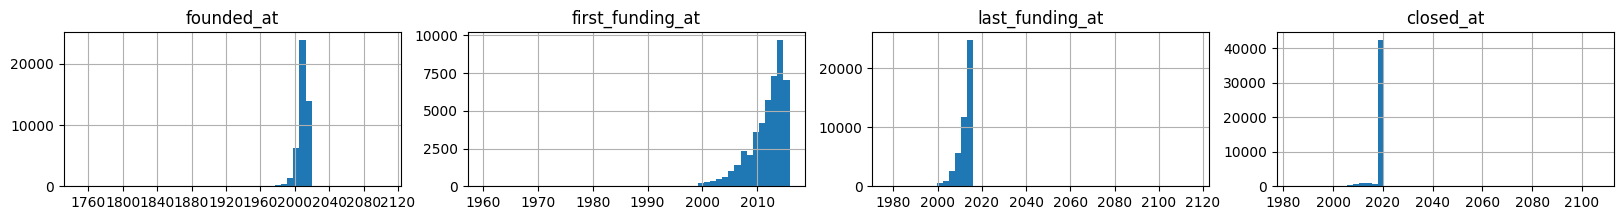

In [ ]:
show_dates(train)

There are entries in `founded_at`, `first_funding_at`, `last_funding_at`, `closed-at` which are earlier than 1980 and later than 2018. So the data was limited by this period

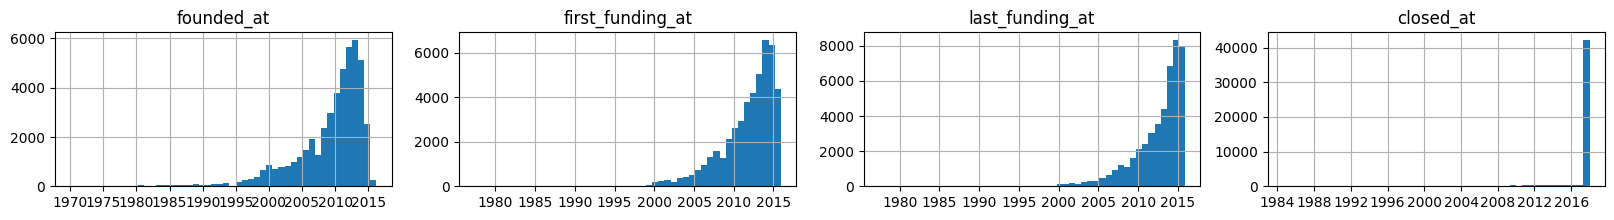

In [ ]:
for column in train.select_dtypes(include=['datetime64']).columns:
    train = train[(train[column]>='1970-01-01') & (train[column]<='2018-01-01')]
show_dates(train)

All date columns have left-skewed distribution.

**Conclusion**  
The exploratory data analysis was be conducted:
- IT sturtups take the highest share (23%). Single-category startups all together (Medicine, Entertainment, Services, Commerce, Manufacturing, Other) are accounted for almost a half of all startups. The sturtups with multiple categories have almost a one third.
- The set of funding_total_usd had statistical outliners which additionally were abnormal. The statistical outliners for funding_total_usd were excluded.
The maximum value is 40315041. The minimum value is 1. The median value is 7552233
- 91% of startups are operating. 9% of startups are closed
- The USA takes over 66%, while Great Britain from the second place takes less then 6%. Other countries in the top 10 are Canada, India, France, Germane, China, Israel, Spain, Australia
- Most of the startups (over 30 000) had the only round. The highest number of funding rounds is 18.
- All date columns have left-skewed distribution.

## 4 Creating new features

In this part the data columns will be transformed into other features for further analysis

In [ ]:
train['days_to_last_funding'] = (train['last_funding_at'] - train['founded_at']).dt.days
train['days_operating'] = (train['closed_at'] - train['founded_at']).dt.days
train = train.drop(['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'], axis=1)

for i in ['days_to_last_funding', 'days_operating']:
    train = train[train[i] >= 0]

Creating new columns:
- days_to_last_funding - days from the foundation to the last funding
- days_operating - days from the foundation to the closing date / unloading date

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44676 entries, 0 to 52878
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  44676 non-null  object 
 1   funding_total_usd     44676 non-null  float64
 2   status                44676 non-null  object 
 3   country_code          44676 non-null  object 
 4   state_code            44676 non-null  object 
 5   region                44676 non-null  object 
 6   city                  44676 non-null  object 
 7   funding_rounds        44676 non-null  int64  
 8   main_cat              44676 non-null  object 
 9   days_to_last_funding  44676 non-null  int64  
 10  days_operating        44676 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 4.1+ MB


## 5 Correlation analysis

In this part the correlation analysis will be conducted to exclude multicollinearity

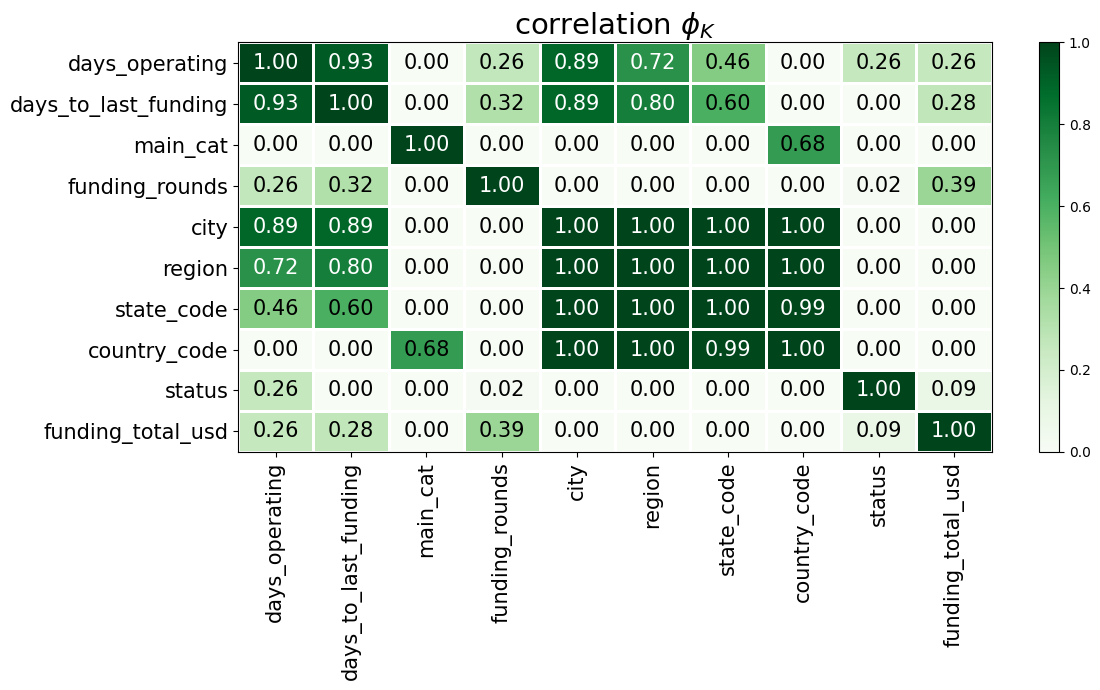

In [ ]:
interval_cols = train.select_dtypes('number').columns

phik_overview = phik_matrix(train.drop('name', axis=1).sample(1000), interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(12, 7)
)

In [ ]:
train = train.drop(['region', 'state_code', 'city'], axis=1)

`city`, `region`, `state_code` `country_code` have high correlation coefficients. The `city`, `region`, `state_code` columns were excluded.

In [ ]:
for i in ['country_code', 'main_cat']:
  train[i] = train[i].astype('category')
train = train.drop('name', axis=1)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44676 entries, 0 to 52878
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   funding_total_usd     44676 non-null  float64 
 1   status                44676 non-null  object  
 2   country_code          44676 non-null  category
 3   funding_rounds        44676 non-null  int64   
 4   main_cat              44676 non-null  category
 5   days_to_last_funding  44676 non-null  int64   
 6   days_operating        44676 non-null  int64   
dtypes: category(2), float64(1), int64(3), object(1)
memory usage: 2.2+ MB


## 6 Model training

The purpose of this part is model training.

In [ ]:
test.loc[test['closed_at'].isna(), 'status'] = 'operating'
test['status'] = test['status'].fillna('closed')

For final evaluation, the target feature was be extracted

In [ ]:
for column in ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']:
    test[column] = pd.to_datetime(test[column], format='%Y-%m-%d')

In [ ]:
get_current_date(test)
get_main_cat(test)

In [ ]:
test['days_to_last_funding'] = (test['last_funding_at'] - test['founded_at']).dt.days
test['days_operating'] = (test['closed_at'] - test['founded_at']).dt.days
test = test.drop(['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'], axis=1)
test = test.drop(['region', 'state_code', 'city'], axis=1)

First, the test data was prepared for training: the required features were extracted from the date info and the category data was transformed based on the previously developed strategy

In [ ]:
X_train = train.drop('status', axis = 1)
X_test = test.drop('status', axis = 1)
y_train = train['status']
y_test = test['status']

The train and test data were divided into two parts each: target and features.

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

print(pd.DataFrame(index=y_train, data=label_encoder.transform(y_train), columns=['LabelEncoder']).drop_duplicates())

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

           LabelEncoder
status                 
operating             1
closed                0


The target was encoded as 1 for `operating` and 0 for `closed`

In [ ]:
cat_columns = X_train.select_dtypes(include=['object', 'category']).columns
num_columns = X_train.select_dtypes(include='number').columns

In [ ]:
num_pipeline = make_imblearn_pipeline(StandardScaler())
column_transformer = make_column_transformer((num_pipeline, num_columns),
                                             (OneHotEncoder(drop='first', sparse_output=False,  max_categories = 30, handle_unknown='ignore'), cat_columns),
                                             remainder='passthrough')
column_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index(['funding_total_usd', 'funding_rounds', 'days_to_last_funding',
       'days_operating'],
      dtype='object')),
                                ('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               max_categories=30,
                                               sparse_output=False),
                                 Index(['country_code', 'main_cat'], dtype='object'))])

Column transformer was created for both categorical and numerical columns

In [ ]:
def objective(trial):
    # the list of hyperparameters for CatBoostClassifier
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "iterations": 10
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    # define the model
    estimator = CatBoostClassifier(**param, verbose=True)

    # implement pipeline
    pipeline = make_imblearn_pipeline(column_transformer,
                         IterativeImputer(),
                         SMOTETomek(),
                         estimator)

    # evaluation
    accuracy = cross_val_score(pipeline, X_train, y_train, cv=3, scoring= 'accuracy').mean()
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)
print(study.best_trial)

[I 2024-04-15 17:01:52,146] A new study created in memory with name: no-name-74d9331b-debe-4577-ba63-2cb3b7e29c15


0:	learn: 0.6744835	total: 17.1ms	remaining: 154ms
1:	learn: 0.6733572	total: 31.7ms	remaining: 127ms
2:	learn: 0.6705028	total: 57.6ms	remaining: 134ms
3:	learn: 0.6701247	total: 80.9ms	remaining: 121ms
4:	learn: 0.6528574	total: 102ms	remaining: 102ms
5:	learn: 0.6520040	total: 132ms	remaining: 88.2ms
6:	learn: 0.6366176	total: 153ms	remaining: 65.7ms
7:	learn: 0.6359884	total: 182ms	remaining: 45.6ms
8:	learn: 0.6347808	total: 232ms	remaining: 25.7ms
9:	learn: 0.6206718	total: 269ms	remaining: 0us


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0:	learn: 0.6644599	total: 27.3ms	remaining: 245ms
1:	learn: 0.6629909	total: 44ms	remaining: 176ms
2:	learn: 0.6402771	total: 61.5ms	remaining: 143ms
3:	learn: 0.6382192	total: 92.4ms	remaining: 139ms
4:	learn: 0.6371270	total: 135ms	remaining: 135ms
5:	learn: 0.6352914	total: 184ms	remaining: 123ms
6:	learn: 0.6341371	total: 207ms	remaining: 88.6ms
7:	learn: 0.6336340	total: 239ms	remaining: 59.8ms
8:	learn: 0.6327225	total: 281ms	remaining: 31.2ms
9:	learn: 0.6313817	total: 322ms	remaining: 0us


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0:	learn: 0.6727070	total: 15.6ms	remaining: 140ms
1:	learn: 0.6712607	total: 31.3ms	remaining: 125ms
2:	learn: 0.6539557	total: 45.8ms	remaining: 107ms
3:	learn: 0.6526460	total: 61.4ms	remaining: 92.2ms
4:	learn: 0.6517996	total: 76.1ms	remaining: 76.1ms
5:	learn: 0.6509558	total: 90.7ms	remaining: 60.4ms
6:	learn: 0.6278189	total: 106ms	remaining: 45.3ms
7:	learn: 0.6266319	total: 121ms	remaining: 30.2ms
8:	learn: 0.6256615	total: 133ms	remaining: 14.8ms
9:	learn: 0.6241595	total: 148ms	remaining: 0us


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2024-04-15 17:04:09,683] Trial 0 finished with value: 0.9164652162234757 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.07178931373581117, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.9164652162234757.


Learning rate set to 0.5
0:	learn: 0.3980122	total: 44.3ms	remaining: 399ms
1:	learn: 0.3477979	total: 83.4ms	remaining: 334ms
2:	learn: 0.2769220	total: 150ms	remaining: 351ms
3:	learn: 0.2328831	total: 200ms	remaining: 300ms
4:	learn: 0.1755818	total: 248ms	remaining: 248ms
5:	learn: 0.1674012	total: 301ms	remaining: 200ms
6:	learn: 0.1574502	total: 345ms	remaining: 148ms
7:	learn: 0.1539793	total: 388ms	remaining: 97ms
8:	learn: 0.1499817	total: 437ms	remaining: 48.5ms
9:	learn: 0.1460364	total: 490ms	remaining: 0us


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.5
0:	learn: 0.3808674	total: 41.7ms	remaining: 375ms
1:	learn: 0.3714247	total: 81.9ms	remaining: 327ms
2:	learn: 0.3512651	total: 130ms	remaining: 303ms
3:	learn: 0.3378701	total: 175ms	remaining: 263ms
4:	learn: 0.3313718	total: 227ms	remaining: 227ms
5:	learn: 0.2789287	total: 278ms	remaining: 185ms
6:	learn: 0.2446023	total: 324ms	remaining: 139ms
7:	learn: 0.2356449	total: 367ms	remaining: 91.6ms
8:	learn: 0.2245542	total: 412ms	remaining: 45.8ms
9:	learn: 0.2122752	total: 463ms	remaining: 0us


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.5
0:	learn: 0.3820698	total: 43.3ms	remaining: 390ms
1:	learn: 0.3239768	total: 81.4ms	remaining: 326ms
2:	learn: 0.3156761	total: 130ms	remaining: 304ms
3:	learn: 0.2550291	total: 172ms	remaining: 258ms
4:	learn: 0.2110606	total: 217ms	remaining: 217ms
5:	learn: 0.2036725	total: 261ms	remaining: 174ms
6:	learn: 0.1840379	total: 309ms	remaining: 133ms
7:	learn: 0.1758370	total: 353ms	remaining: 88.3ms
8:	learn: 0.1757623	total: 366ms	remaining: 40.7ms
9:	learn: 0.1632603	total: 408ms	remaining: 0us


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2024-04-15 17:06:26,145] Trial 1 finished with value: 0.9422284895693438 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.08124564265431268, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.978473218488664}. Best is trial 1 with value: 0.9422284895693438.


0:	learn: 0.6930590	total: 27.3ms	remaining: 246ms
1:	learn: 0.6930590	total: 36.9ms	remaining: 147ms
2:	learn: 0.6756180	total: 50.5ms	remaining: 118ms
3:	learn: 0.6754891	total: 61.7ms	remaining: 92.6ms
4:	learn: 0.6754035	total: 74.2ms	remaining: 74.2ms
5:	learn: 0.6752590	total: 87ms	remaining: 58ms
6:	learn: 0.6751960	total: 98.2ms	remaining: 42.1ms
7:	learn: 0.6750497	total: 112ms	remaining: 28ms
8:	learn: 0.6587524	total: 123ms	remaining: 13.7ms
9:	learn: 0.6585916	total: 134ms	remaining: 0us


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0:	learn: 0.6930600	total: 9.27ms	remaining: 83.5ms
1:	learn: 0.6930600	total: 15.1ms	remaining: 60.5ms
2:	learn: 0.6921548	total: 23.1ms	remaining: 53.8ms
3:	learn: 0.6910340	total: 30.6ms	remaining: 45.9ms
4:	learn: 0.6906829	total: 40.2ms	remaining: 40.2ms
5:	learn: 0.6904961	total: 52.5ms	remaining: 35ms
6:	learn: 0.6903451	total: 61.8ms	remaining: 26.5ms
7:	learn: 0.6903376	total: 71ms	remaining: 17.8ms
8:	learn: 0.6902180	total: 78.6ms	remaining: 8.73ms
9:	learn: 0.6900092	total: 88.2ms	remaining: 0us


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2024-04-15 17:08:43,507] Trial 2 finished with value: 0.6687259378637299 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.028111364268572914, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.9422284895693438.


0:	learn: 0.6927896	total: 9.26ms	remaining: 83.4ms
1:	learn: 0.6927889	total: 14.6ms	remaining: 58.3ms
2:	learn: 0.6914736	total: 22.4ms	remaining: 52.4ms
3:	learn: 0.6912460	total: 31ms	remaining: 46.4ms
4:	learn: 0.6912081	total: 39.5ms	remaining: 39.5ms
5:	learn: 0.6900583	total: 47.5ms	remaining: 31.7ms
6:	learn: 0.6899127	total: 55.8ms	remaining: 23.9ms
7:	learn: 0.6898789	total: 64.9ms	remaining: 16.2ms
8:	learn: 0.6897813	total: 75.1ms	remaining: 8.34ms
9:	learn: 0.6896748	total: 84.3ms	remaining: 0us
0:	learn: 0.6563986	total: 144ms	remaining: 1.3s
1:	learn: 0.6406157	total: 291ms	remaining: 1.16s
2:	learn: 0.6134056	total: 457ms	remaining: 1.07s
3:	learn: 0.6124143	total: 606ms	remaining: 908ms
4:	learn: 0.6118911	total: 759ms	remaining: 759ms
5:	learn: 0.6104966	total: 921ms	remaining: 614ms
6:	learn: 0.6052886	total: 1.07s	remaining: 461ms
7:	learn: 0.6046101	total: 1.19s	remaining: 298ms
8:	learn: 0.6030691	total: 1.35s	remaining: 150ms
9:	learn: 0.6015056	total: 1.48s	rem

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0:	learn: 0.6889930	total: 146ms	remaining: 1.31s
1:	learn: 0.6602240	total: 289ms	remaining: 1.16s
2:	learn: 0.6576772	total: 441ms	remaining: 1.03s
3:	learn: 0.6210689	total: 584ms	remaining: 877ms
4:	learn: 0.5975572	total: 733ms	remaining: 733ms
5:	learn: 0.5667222	total: 902ms	remaining: 601ms
6:	learn: 0.5544398	total: 1.06s	remaining: 453ms
7:	learn: 0.5538497	total: 1.19s	remaining: 297ms
8:	learn: 0.5511267	total: 1.32s	remaining: 147ms
9:	learn: 0.5325755	total: 1.46s	remaining: 0us


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0:	learn: 0.6593254	total: 156ms	remaining: 1.41s
1:	learn: 0.6326778	total: 313ms	remaining: 1.25s
2:	learn: 0.6309736	total: 473ms	remaining: 1.1s
3:	learn: 0.6295522	total: 667ms	remaining: 1000ms
4:	learn: 0.6288408	total: 883ms	remaining: 883ms
5:	learn: 0.6089501	total: 1.2s	remaining: 798ms
6:	learn: 0.6066660	total: 1.55s	remaining: 664ms
7:	learn: 0.6044819	total: 1.79s	remaining: 447ms
8:	learn: 0.6034316	total: 2.04s	remaining: 226ms


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2024-04-15 17:11:02,427] Trial 3 finished with value: 0.9188154713940371 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.07797195835288832, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7340939455089692}. Best is trial 1 with value: 0.9422284895693438.


9:	learn: 0.5827773	total: 2.26s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6439584	total: 24ms	remaining: 216ms
1:	learn: 0.3959360	total: 43.9ms	remaining: 176ms
2:	learn: 0.3516878	total: 67.4ms	remaining: 157ms
3:	learn: 0.3209232	total: 90.6ms	remaining: 136ms
4:	learn: 0.3081777	total: 117ms	remaining: 117ms
5:	learn: 0.2857569	total: 140ms	remaining: 93.6ms
6:	learn: 0.2658198	total: 166ms	remaining: 71.1ms
7:	learn: 0.2322237	total: 196ms	remaining: 49.1ms
8:	learn: 0.2289585	total: 227ms	remaining: 25.2ms
9:	learn: 0.1917178	total: 250ms	remaining: 0us


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.5
0:	learn: 0.3806057	total: 22.4ms	remaining: 201ms
1:	learn: 0.3216839	total: 42.9ms	remaining: 172ms
2:	learn: 0.3170222	total: 64.3ms	remaining: 150ms
3:	learn: 0.3019985	total: 85.4ms	remaining: 128ms
4:	learn: 0.2917168	total: 106ms	remaining: 106ms
5:	learn: 0.2825712	total: 129ms	remaining: 85.9ms
6:	learn: 0.2716032	total: 156ms	remaining: 66.8ms
7:	learn: 0.2675190	total: 189ms	remaining: 47.3ms
8:	learn: 0.2432883	total: 211ms	remaining: 23.5ms
9:	learn: 0.2396664	total: 233ms	remaining: 0us


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.5
0:	learn: 0.6665875	total: 20ms	remaining: 180ms
1:	learn: 0.6552724	total: 40.9ms	remaining: 163ms
2:	learn: 0.4043297	total: 60.7ms	remaining: 142ms
3:	learn: 0.3481701	total: 84.6ms	remaining: 127ms
4:	learn: 0.3426957	total: 105ms	remaining: 105ms
5:	learn: 0.3409970	total: 125ms	remaining: 83.4ms
6:	learn: 0.3355670	total: 149ms	remaining: 63.9ms
7:	learn: 0.3015525	total: 167ms	remaining: 41.8ms


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2024-04-15 17:13:18,438] Trial 4 finished with value: 0.915637031068135 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09448323032128061, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.2615381444944425}. Best is trial 1 with value: 0.9422284895693438.


8:	learn: 0.2852300	total: 197ms	remaining: 21.8ms
9:	learn: 0.2724976	total: 222ms	remaining: 0us
FrozenTrial(number=1, state=TrialState.COMPLETE, values=[0.9422284895693438], datetime_start=datetime.datetime(2024, 4, 15, 17, 4, 9, 684848), datetime_complete=datetime.datetime(2024, 4, 15, 17, 6, 26, 145446), params={'objective': 'Logloss', 'colsample_bylevel': 0.08124564265431268, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.978473218488664}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'objective': CategoricalDistribution(choices=('Logloss', 'CrossEntropy')), 'colsample_bylevel': FloatDistribution(high=0.1, log=False, low=0.01, step=None), 'depth': IntDistribution(high=12, log=False, low=1, step=1), 'boosting_type': CategoricalDistribution(choices=('Ordered', 'Plain')), 'bootstrap_type': CategoricalDistribution(choices=('Bayesian', 'Bernoulli', 'MVS')), 'bagging_temperature': FloatDistribution(high=10.0, log=Fa

CatboostClassifier model was chosen as the base model. The hyperparameters were tuned with Optuna. The best parameters for the model are presented below.

In [ ]:
study.best_params

{'objective': 'Logloss',
 'colsample_bylevel': 0.08124564265431268,
 'depth': 9,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'bagging_temperature': 2.978473218488664}

In [ ]:
pipeline = make_imblearn_pipeline(column_transformer,
                  IterativeImputer(),
                  SMOTETomek(),
                  CatBoostClassifier(**study.best_params)
                  )

In [ ]:
pipeline.fit(X_train, y_train)

Learning rate set to 0.067527
0:	learn: 0.6267326	total: 54ms	remaining: 53.9s
1:	learn: 0.6246393	total: 96.5ms	remaining: 48.2s
2:	learn: 0.5668704	total: 161ms	remaining: 53.4s
3:	learn: 0.5293305	total: 236ms	remaining: 58.6s
4:	learn: 0.5247292	total: 300ms	remaining: 59.7s
5:	learn: 0.5005427	total: 353ms	remaining: 58.6s
6:	learn: 0.4959944	total: 420ms	remaining: 59.6s
7:	learn: 0.4939518	total: 484ms	remaining: 1m
8:	learn: 0.4913308	total: 543ms	remaining: 59.8s
9:	learn: 0.4647885	total: 605ms	remaining: 59.9s
10:	learn: 0.4249217	total: 663ms	remaining: 59.6s
11:	learn: 0.4142176	total: 731ms	remaining: 1m
12:	learn: 0.4113755	total: 784ms	remaining: 59.5s
13:	learn: 0.4001248	total: 836ms	remaining: 58.9s
14:	learn: 0.3986070	total: 896ms	remaining: 58.9s
15:	learn: 0.3971942	total: 961ms	remaining: 59.1s
16:	learn: 0.3926554	total: 1.01s	remaining: 58.6s
17:	learn: 0.3921964	total: 1.04s	remaining: 56.6s
18:	learn: 0.3882724	total: 1.1s	remaining: 56.9s
19:	learn: 0.37802

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['funding_total_usd', 'funding_rounds', 'days_to_last_funding',
       'days_operating'],
      dtype='object')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                max_categories=30,
                                                                sparse_output=False),
                                                  Index(['country_code', 'main_cat'], dtype='object'))])),
                ('iterativeimputer', IterativeImputer()),
                ('smotetomek', SMOTETomek()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7f7723f2c280>)])

The model with the best parameters was trained on the training data

## 7 Model evaluation

In [ ]:
y_pred = pipeline.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


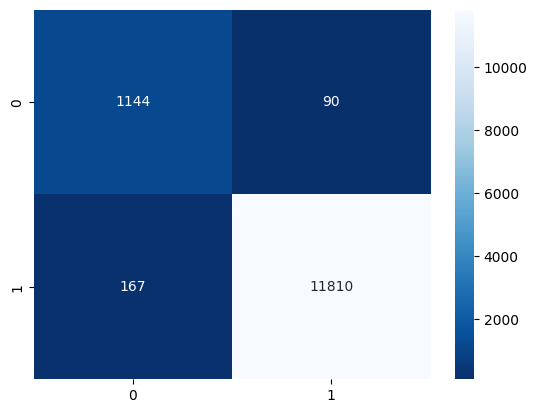

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');

In [ ]:
bm_score = f1_score(y_pred, y_test, pos_label=0)

In [ ]:
bm_score

0.8990176817288802

The prediction f1 score is 0.899. There are 167 false negatives

## 8 Model correction

To minimize false negatives a new threshold will be set.

In [ ]:
pred_levels = pd.DataFrame(columns = ['threshold', 'false_negative', 'false_positive', 'precision', 'recall', 'f_1'])
thresholds = [round(i,2) for i in np.linspace(0.1,1,num = 100,endpoint=False)]

for i in thresholds:
    y_proba = pipeline.predict_proba(X_test)[:,1]
    data = pd.DataFrame(zip(y_test, y_proba), columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

    data['pred'] = data['y_proba'].apply(lambda x: 0 if x < i else 1)
    data.loc[data['y_valid'] - data['pred'] == 1, 'false_negative'] = 1
    data.loc[data['y_valid'] - data['pred'] == -1, 'false_positive'] = 1
    precision = precision_score(data['y_valid'], data['pred'], zero_division=0.0)
    recall = recall_score(data['y_valid'], data['pred'])
    false_negative = data.sum()['false_negative']
    false_positive = data.sum()['false_positive']
    f_1 = f1_score(data['y_valid'], data['pred'], pos_label=0)
    pred_levels.loc[len(pred_levels)] =[i, false_negative, false_positive, precision, recall, f_1]
print(pred_levels.sort_values('f_1', ascending=False).iloc[0])
threshold = pred_levels.sort_values('f_1', ascending=False).iloc[0].threshold
threshold

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found u

threshold           0.270000
false_negative     35.000000
false_positive    146.000000
precision           0.987922
recall              0.997078
f_1                 0.923207
Name: 19, dtype: float64


0.27

In [ ]:
pipeline.steps[3][1].set_probability_threshold(threshold)

In [ ]:
y_pred = pipeline.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


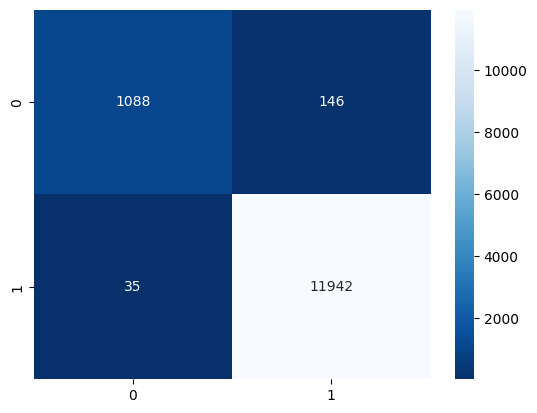

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');

In [ ]:
f1_score(y_test, y_pred, pos_label=0)

0.9232074671192193

After setting the new threshold, the number of false negatives is 35 instead of 167. The new f1 score was also improved and became 0.923

## 9 Feature importance analysis

In this part the most important features will be defined

In [ ]:
features_names = pipeline.steps[0][1].get_feature_names_out()

In [ ]:
X_train_ = pipeline.steps[0][1].fit_transform(X_train)
X_test_ = pipeline.steps[0][1].transform(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
X_train_ = pd.DataFrame(X_train_, columns = features_names)
X_test_ = pd.DataFrame(X_test_, columns = features_names)

In [ ]:
feature_importances = pd.DataFrame(
    {
        'Feature': features_names,
        'Importance': pipeline.steps[3][1].feature_importances_
    })
feature_importances.sort_values(by='Importance', ascending=False)

,Feature,Importance
3,pipeline__days_operating,52.412337
2,pipeline__days_to_last_funding,34.091886
1,pipeline__funding_rounds,2.791732
31,onehotencoder__country_code_USA,2.211561
0,pipeline__funding_total_usd,1.030997
...,...,...
5,onehotencoder__country_code_BEL,0.015577
36,"onehotencoder__main_cat_Commerce, IT, Entertai...",0.015044
26,onehotencoder__country_code_POL,0.009605
24,onehotencoder__country_code_MEX,0.006951


In [ ]:
explainer = shap.TreeExplainer(pipeline.steps[3][1])
shap_values = explainer(X_test_, y_test)

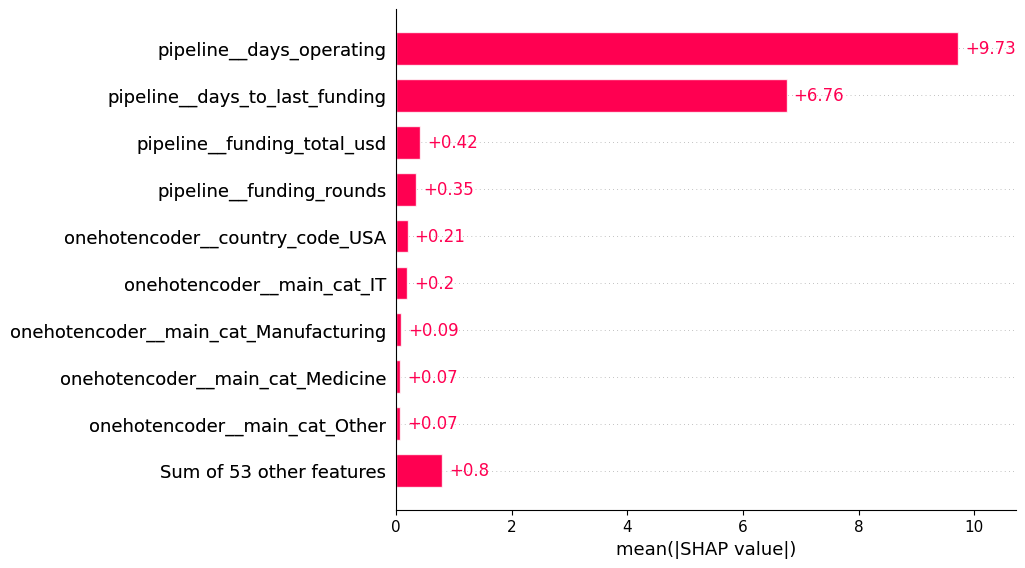

In [ ]:
shap.plots.bar(shap_values, max_display=10)

Startup's lifetime and the time from its foundation to last funding have the strongest influence on the chances for startup closure.

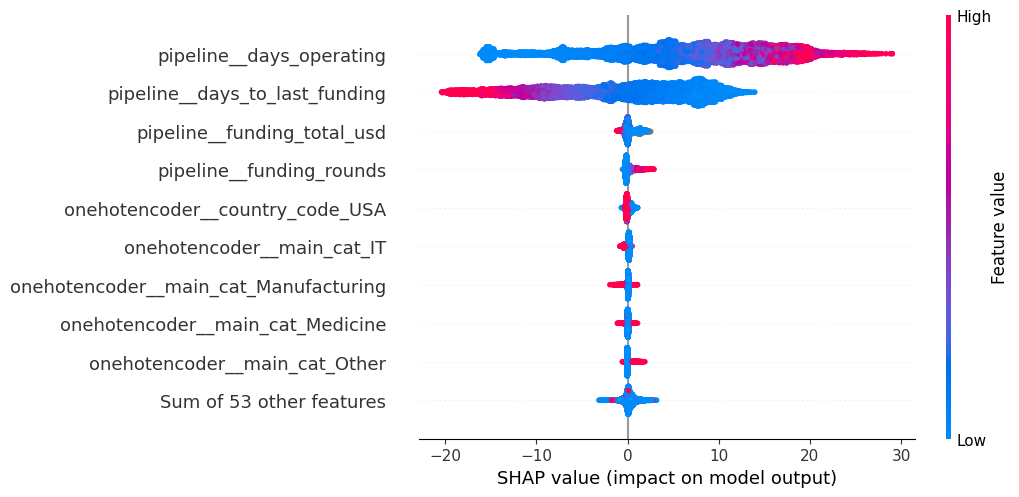

In [ ]:
shap.plots.beeswarm(shap_values, max_display=10)

According to the graph, the longer startup's lifetime, higher lower chances that it won't close. Also, the more days it's been from the foundation date to the last funding the lower chances that it won't close. Moreover, the more funding rounds the higher chances for success

## 10 Conclusion

In this research the anylysis of the data on startups operating between 1980 and 2018 was conducted  

The result of the research is the model predicting the startup closure based on such parameters as its category, funding rounds quantity and total funding amount, dates of foundation, first and last funding. **The final f1 score is 0.92**  with 1088 correctly predicted closed startups and 35 incorrectly predicted operating startups.

Startup's lifetime and the time from its foundation to the last funding have the strongest influence on the chances for startup closure

In [ ]:
df = pd.DataFrame(X_test.name, columns = ['name'])
df['status'] = y_pred
df.loc[df['status'] == 1, 'status'] = 'operating'
df.loc[df['status'] == 0, 'status'] = 'closed'
df

,name,pred
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating
...,...,...
13206,Jymob,operating
13207,GlobaTrek,operating
13208,Inkd.com,operating
13209,AdWill,operating
